In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('F:\Jupyter\Music\ML\Classical-Music-Midi'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
# !pip install music21
# !apt-get install -y lilypond

F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_esp1.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_esp2.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_esp3.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_esp4.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_esp5.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_esp6.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se1.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se2.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se3.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se4.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se5.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se6.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se7.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\albeniz\alb_se8.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\bach\bach_846.mid
F:\Jupyter\Music\ML\Classical-Music-Midi\bach\bach_847.mid
F:\Jupyter\Music\ML\Cl

In [2]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
#Loading the list of chopin's midi files as stream 
filepath = "F:\\Jupyter\\Music\\ML\\Classical-Music-Midi\\bach\\"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [4]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)[:500]
print("Total notes in all the Bach midis in the dataset:", len(Corpus))

Total notes in all the Bach midis in the dataset: 500


In [5]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'C4', 'E4']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

In [6]:
env = environment.Environment()
environment.Environment()['lilypondPath'] = r'E:\break-app\LilyPond\usr\bin\lilypond-windows.exe'

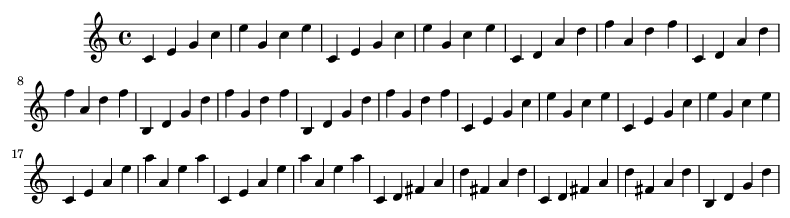

In [7]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

**Playing the above sheet music** 

*As I could not play a midi file on the Kaggle interface, I have created a ".wav" filetype of the same outside of this code. I am using it to create an audio interface. Let us have a listen to the data corpus.* 

#to play audio or corpus
print("Sample Audio From Data")
IPython.display.Audio("../input/music-generated-lstm/Corpus_Snippet.wav") 

**Examine all the notes in the Corpus** 

In [8]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 31


In [9]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 16.129032258064516
Most frequent note in Corpus appeared: 66 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes. 
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

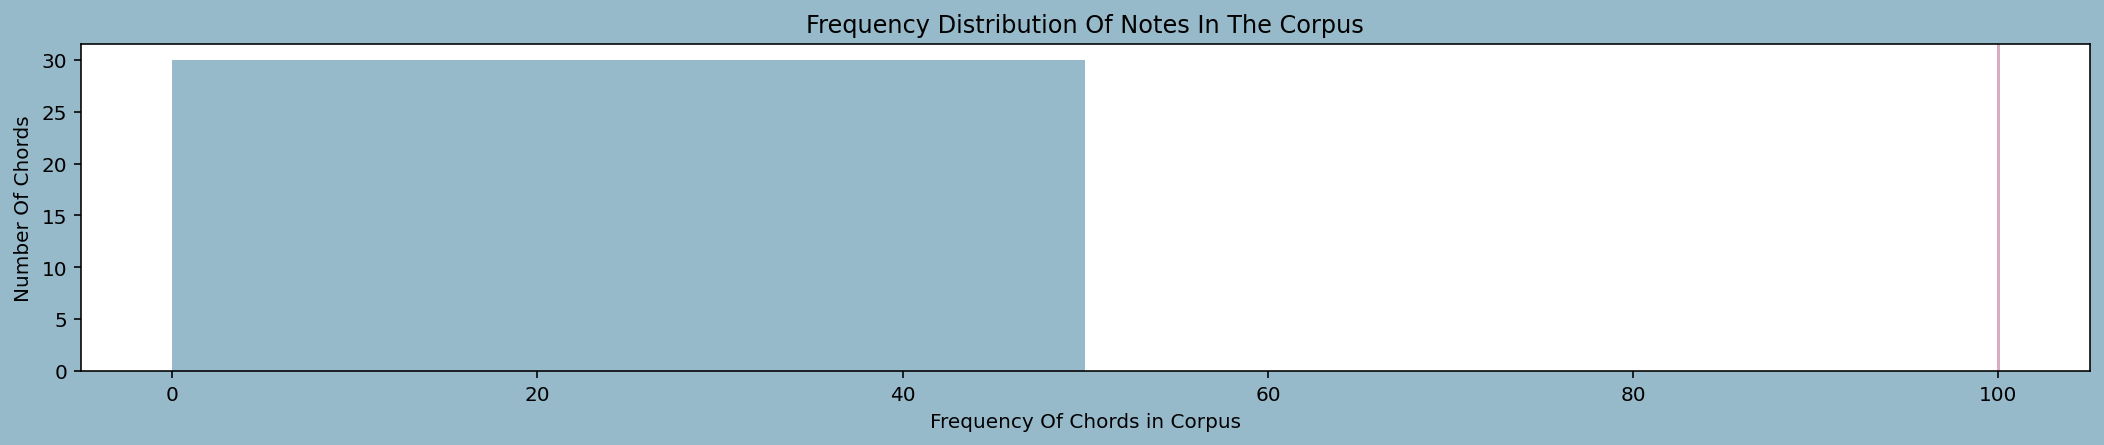

In [10]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section. 

#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

In [11]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 500
Number of unique characters: 31


**Encoding and Splitting the Corpus as Labels and Targets**

In [12]:
#Splitting the Corpus in equal length of strings and output target
length = 256
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 244


In [13]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

**Splitting Train and Seed datasets**

In [14]:
#Taking out a subset of data to be used as seed
X_train, X_seed0, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train[:,:,0]

array([[10,  9, 29, ..., 11, 28,  4],
       [22, 26, 12, ..., 28,  9, 29],
       [ 4, 12, 29, ...,  0,  9, 15],
       ...,
       [13, 20,  1, ...,  8,  0,  9],
       [29,  6, 17, ..., 27, 14,  0],
       [13, 30,  4, ...,  9, 12,  4]])

In [16]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
# train the data and see its score
rfc = RandomForestClassifier()
rfc.fit(X_train[:,:,0],y_train)
prediction_rfc = rfc.predict(X_train[ :,:,0])
print("Training accuracy = %f"%(np.mean(y_train == prediction_rfc)))

Training accuracy = 1.000000


In [19]:
prediction_rfc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

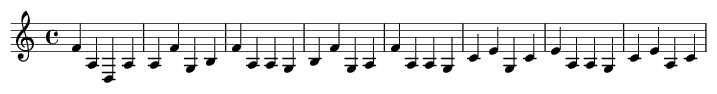

In [20]:
def Malody_Generator(Note_Count):
    seed = X_seed0[np.random.randint(0,len(X_seed0)-1)]
    Music = []
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length)
        # print(seed)
        prediction = rfc.predict(seed)
        # print(prediction)
        index = np.argmax(prediction) 
        Music.append(reverse_mapping[index])
        seed = np.insert(seed[0],len(seed[0]),index)
        # print(index)
        seed = seed[1:]
        # print(seed)
    # Now, we have music in form or a list of chords and notes and we want to be a midi file.
    # print(Notes_Generated)
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(32)
show(Melody)

This sure looks like music! To check if it sounds like music we have to listen to the MIDI file. Playing midi is crumblesome. I have saved and converted a few generated melodies to ".wav" format outside of this notebook. So let us have a listen. 

**Melody Generated Sample 1**

In [21]:
# To save the generated melody
Melody.write('midi','Melody_Generated.mid')
# to play audio or corpus
# IPython.display.Audio("F:/Jupyter/Music/ML/Melody_Generated.mid"):
# Audio('F:/Jupyter/Music/ML/Melody_Generated.mid', autoplay=True)

'Melody_Generated.mid'

**Melody Generated Sample 2**

#to play audio or corpus
IPython.display.Audio("../input/music-generated-lstm/Melody_Generated_1.wav")